In [22]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from numpy.linalg import norm
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

Wondering if forecasting performance improves if I give the difference of x_n with x_n-1 as a separate input, the performance of the reservoir improves.

Currently, this is what I have, also, fixed the bias term.

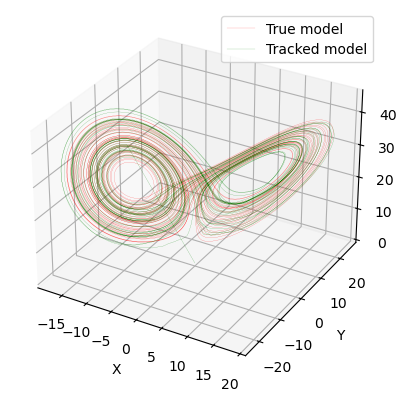

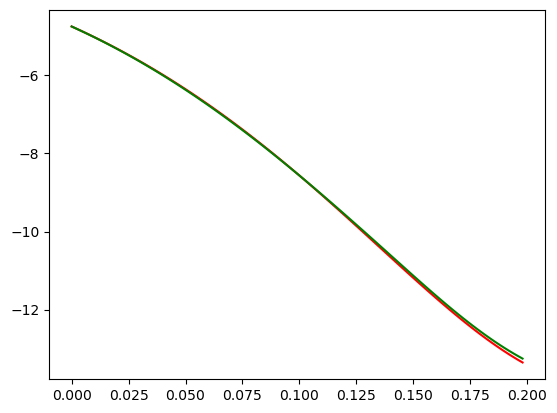

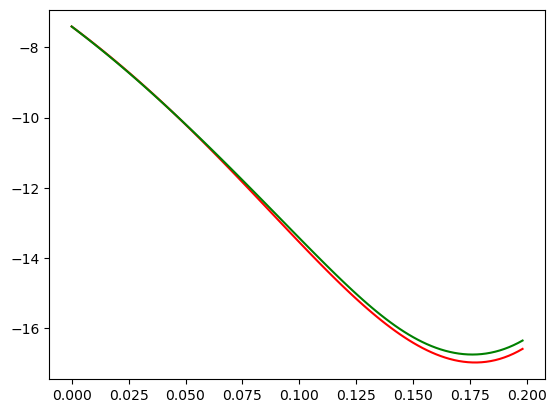

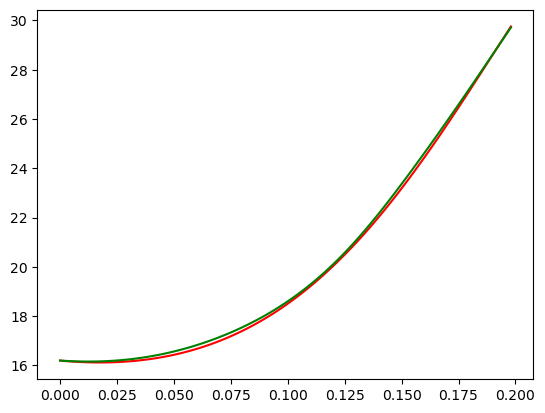

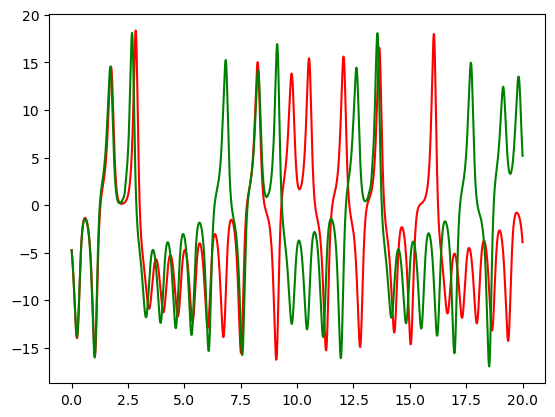

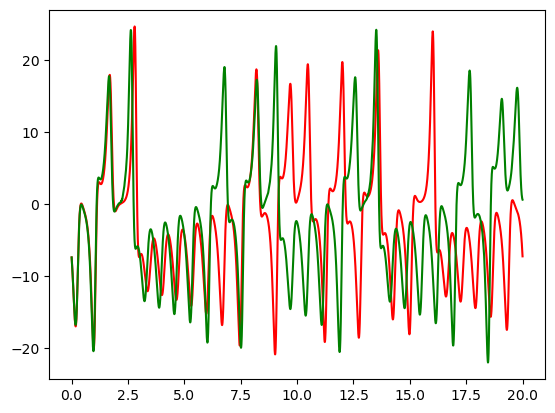

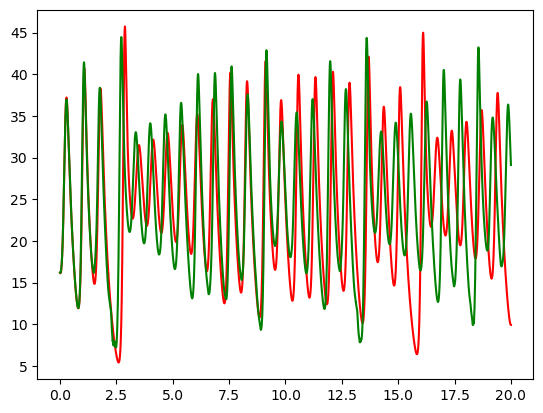

In [7]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3 + 1                       # number of dimensions in the system + 1 for bias
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.00001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density = 6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)


## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z, 1])
    R[:, t] = r
    

    xp = sigma * (y - x) 
    yp = x * (rho - z) - y 
    zp = x * y - beta * z 

    x += dt * xp
    y += dt * yp
    z += dt * zp

    r = np.tanh(A.dot(r) + Win.dot(u))
    f[:, t] = np.array(u)


## Using only last 10000 data points for training
#f = f[:, -10000:] 
#R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 50
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xtrack = np.zeros(ntest + 1)             
ytrack = np.zeros(ntest + 1)
ztrack = np.zeros(ntest + 1)

xxpure, yypure, zzpure = x, y, z
xxpid, yypid, zzpid = x, y, z
xtrack[0], ytrack[0], ztrack[0] = x, y, z
xxtrack, yytrack, zztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system
    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## Actual system
    
    
    r = np.tanh(A.dot(r) + Win.dot(np.array([xxtrack, yytrack, zztrack, 1])))
    xxtrack, yytrack, zztrack = Wout.dot(r)[: m - 1]
    
    

    xtrack[t] = xxtrack
    ytrack[t] = yytrack
    ztrack[t] = zztrack



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'True model')
ax.plot3D(xtrack, ytrack, ztrack, 'g', linewidth = 0.1, label = 'Tracked model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
#avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

#print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
# A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
# B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
# avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
# print('Average of minimum distances:', avgdist)

## Plotting x and y time series data of ideal and tracked model

plottimerange = np.arange(0, 100)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xtrack[plottimerange],  'g', label = 'Tracked model')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ytrack[plottimerange],  'g', label = 'Tracked model')
plt.show()


plt.figure()
plt.plot(testingtimes[plottimerange], zpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ztrack[plottimerange],  'g', label = 'Tracked model')
plt.show()

plottimerange = np.arange(0, 10000)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xtrack[plottimerange],  'g', label = 'Tracked model')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ytrack[plottimerange],  'g', label = 'Tracked model')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], zpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ztrack[plottimerange],  'g', label = 'Tracked model')
plt.show()



Adding the bias term this way, actually seems to make it worse for some reason. Having the extra row of tunable weights in Wout matrix seems to make it worse which is interesting.

So, just going back to the older version.

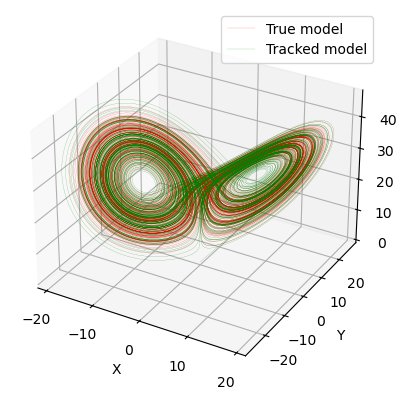

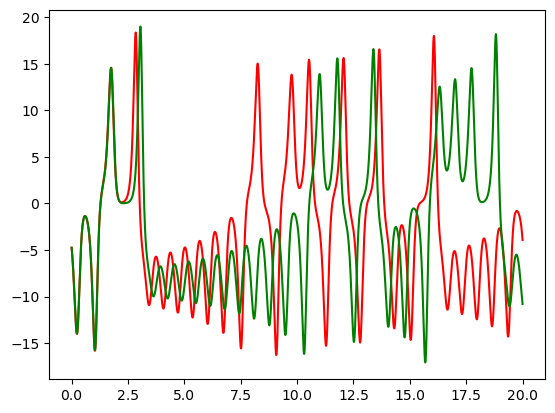

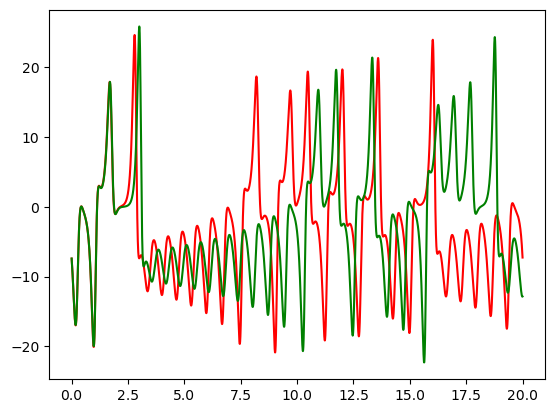

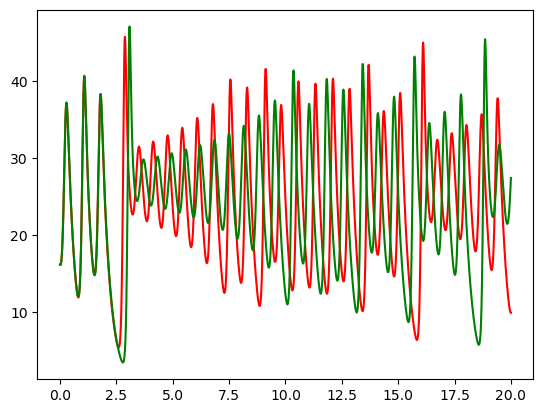

In [26]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.00001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)
#A = np.zeros((n, n))

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x) #+ np.random.normal(0, 0.1)
    yp = x * (rho - z) - y #+ np.random.normal(0, 0.1) 
    zp = x * y - beta * z #+ np.random.normal(0, 0.1)

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + np.ones(n))
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u


## Using only last 10000 data points for training
#f = f[:, -10000:] 
#R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)
zpid = np.zeros(ntest + 1)

## For storing error time series data
err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxpid, yypid, zzpid = x, y, z
xpid[0], ypid[0], zpid[0] = x, y, z
xtrack, ytrack, ztrack = x, y, z


## Time evolution
for t in range(ntest):

    ## Ideal system
    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## Actual system
    
    
    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xtrack, ytrack, ztrack])) + np.ones(n))
    xtrack, ytrack, ztrack = Wout_pid.dot(rpid)
    
    

    xpid[t] = xtrack
    ypid[t] = ytrack
    zpid[t] = ztrack



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'True model')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.1, label = 'Tracked model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
#avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

#print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
# A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
# B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
# avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
# print('Average of minimum distances:', avgdist)

# plottimerange = np.arange(0, 100)

# plt.figure()
# plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
# plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Tracked model')
# plt.show()

# plt.figure()
# plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
# plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Tracked model')
# plt.show()

# plt.figure()
# plt.plot(testingtimes[plottimerange], zpure[plottimerange], 'r', label = 'True model')
# plt.plot(testingtimes[plottimerange], zpid[plottimerange],  'g', label = 'Tracked model')
# plt.show()

plottimerange = np.arange(0, 10000)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Tracked model')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Tracked model')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], zpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], zpid[plottimerange],  'g', label = 'Tracked model')
plt.show()

Adding the difference as an element in the vector:

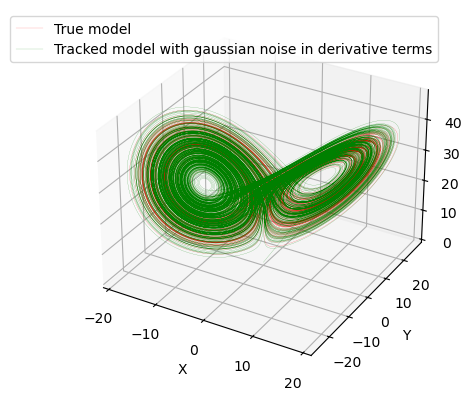

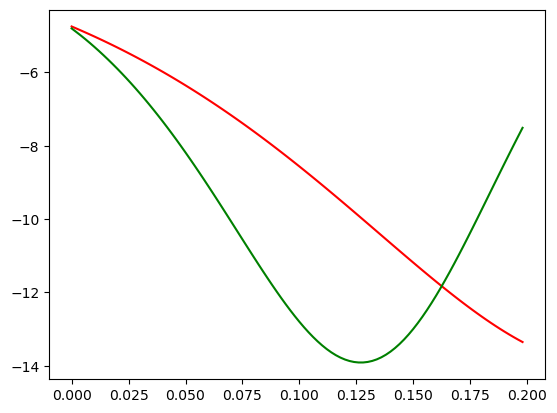

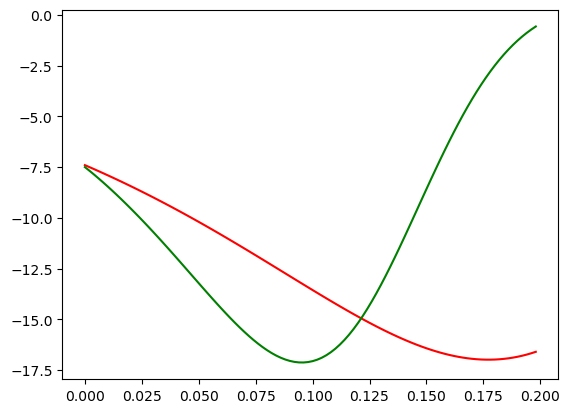

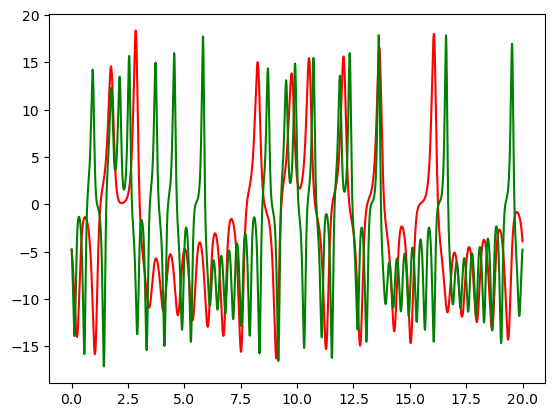

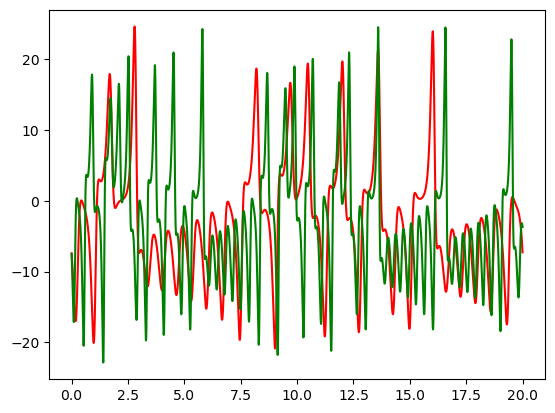

In [10]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3 * 2                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.00001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)
#A = np.zeros((n, n))

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

xdiff, ydiff, zdiff = x, y, z

## Collecting reservoir time-series data
for t in range(ntraining):

    if t > 0:
        xdiff = x - f[0, t - 1]
        ydiff = y - f[1, t - 1]
        zdiff = z - f[2, t - 1]
    u = np.array([x, y, z, xdiff, ydiff, zdiff])

    R[:, t] = rpid
    

    xp = sigma * (y - x) #+ np.random.normal(0, 0.1)
    yp = x * (rho - z) - y #+ np.random.normal(0, 0.1) 
    zp = x * y - beta * z #+ np.random.normal(0, 0.1)

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)

    f[:, t] = np.array([x, y, z, xdiff, ydiff, zdiff])
    



## Using only last 10000 data points for training
#f = f[:, -10000:] 
#R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)
zpid = np.zeros(ntest + 1)

## For storing error time series data
err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxpid, yypid, zzpid = x, y, z
xpid[0], ypid[0], zpid[0] = x, y, z
xtrack, ytrack, ztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system
    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## Actual system
    
    
    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xtrack, ytrack, ztrack, xdiff, ydiff, zdiff])) 
                   + np.ones(n))
    xtrack, ytrack, ztrack = Wout_pid.dot(rpid)[0 : 3]
    xdiff, ydiff, zdiff = Wout_pid.dot(rpid)[3 : 6]

    xpid[t] = xtrack
    ypid[t] = ytrack
    zpid[t] = ztrack



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'True model')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.1, label = 'Tracked model with gaussian noise in derivative terms')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
#avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

#print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
# A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
# B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
# avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
# print('Average of minimum distances:', avgdist)

plottimerange = np.arange(0, 100)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Tracked model')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Tracked model')
plt.show()

plottimerange = np.arange(0, 10000)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Tracked model')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Tracked model')
plt.show()

Try with just the previous value instead of difference.

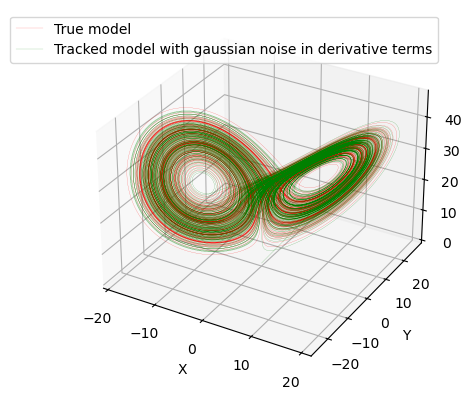

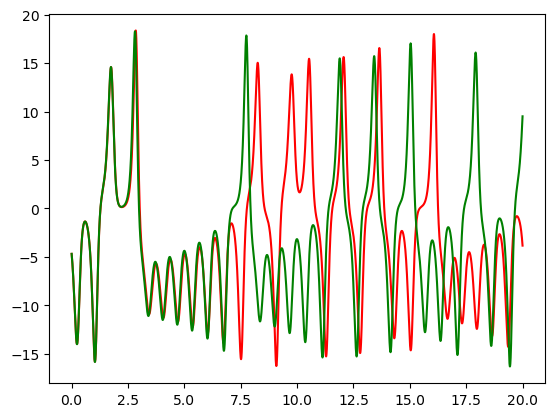

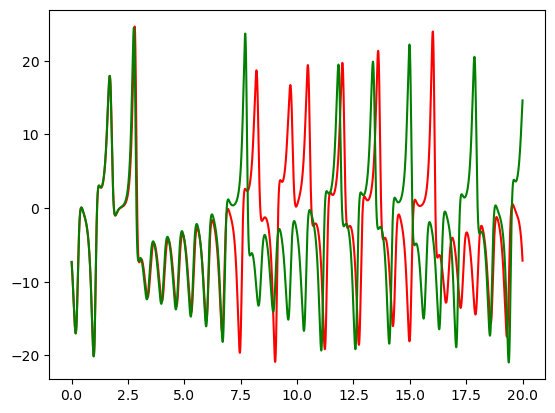

In [27]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3 * 2                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.00001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)
#A = np.zeros((n, n))

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

xprev, yprev, zprev = x, y, z

## Collecting reservoir time-series data
for t in range(ntraining):

    

    f[:, t] = np.array([x, y, z, xprev, yprev, zprev])
    R[:, t] = rpid
    
    xprev, yprev, zprev = x, y, z

    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([x, y, z, xprev, yprev, zprev])) + 1)

    xp = sigma * (y - x) #+ np.random.normal(0, 0.1)
    yp = x * (rho - z) - y #+ np.random.normal(0, 0.1) 
    zp = x * y - beta * z #+ np.random.normal(0, 0.1)

    x += dt * xp
    y += dt * yp
    z += dt * zp

    

    
    
    



## Using only last 10000 data points for training
#f = f[:, -10000:] 
#R = R[:, -10000:]


## Finding Wout matrix using ridge regression
f = f[0:3, :]
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)
zpid = np.zeros(ntest + 1)

## For storing error time series data
err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxpid, yypid, zzpid = x, y, z
xpid[0], ypid[0], zpid[0] = x, y, z
xtrack, ytrack, ztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure 

    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

      

    ## Actual system

    xpid[t] = xtrack
    ypid[t] = ytrack
    zpid[t] = ztrack
    
    xprev, yprev, zprev = xtrack, ytrack, ztrack

    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xtrack, ytrack, ztrack, xprev, yprev, zprev])) 
                   + np.ones(n))
    xtrack, ytrack, ztrack = Wout_pid.dot(rpid)[0 : 3]

    



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'True model')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.1, label = 'Tracked model with gaussian noise in derivative terms')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
#avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

#print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
# A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
# B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
# avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
# print('Average of minimum distances:', avgdist)

# plottimerange = np.arange(0, 100)

# plt.figure()
# plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
# plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Tracked model')
# plt.show()

# plt.figure()
# plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
# plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Tracked model')
# plt.show()

plottimerange = np.arange(0, 10000)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Tracked model')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Tracked model')
plt.show()

Forecast with disturbance: Just take a system with disturbances, learn from it, and then forecast with it.

Also do lyapunov exponent.

In [ ]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3 * 2                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.00001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)
#A = np.zeros((n, n))

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

xdiff, ydiff, zdiff = x, y, z

## Collecting reservoir time-series data
for t in range(ntraining):

    if t > 0:
        xdiff = x - f[0, t - 1]
        ydiff = y - f[1, t - 1]
        zdiff = z - f[2, t - 1]
    u = np.array([x, y, z, xdiff, ydiff, zdiff])

    R[:, t] = rpid
    

    xp = sigma * (y - x) #+ np.random.normal(0, 0.1)
    yp = x * (rho - z) - y #+ np.random.normal(0, 0.1) 
    zp = x * y - beta * z #+ np.random.normal(0, 0.1)

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)

    f[:, t] = u
    



## Using only last 10000 data points for training
#f = f[:, -10000:] 
#R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)
zpid = np.zeros(ntest + 1)

## For storing error time series data
err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxpid, yypid, zzpid = x, y, z
xpid[0], ypid[0], zpid[0] = x, y, z
xtrack, ytrack, ztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system
    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## Actual system
    
    
    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xtrack, ytrack, ztrack, xdiff, ydiff, zdiff])) 
                   + np.ones(n))
    xtrack, ytrack, ztrack = Wout_pid.dot(rpid)[0 : 3]
    xdiff, ydiff, zdiff = Wout_pid.dot(rpid)[3 : 6]

    xpid[t] = xtrack
    ypid[t] = ytrack
    zpid[t] = ztrack



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'True model')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.1, label = 'Tracked model with gaussian noise in derivative terms')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
#avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

#print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
# A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
# B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
# avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
# print('Average of minimum distances:', avgdist)

plottimerange = np.arange(0, 100)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Tracked model')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Tracked model')
plt.show()

plottimerange = np.arange(0, 10000)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Tracked model')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Tracked model')
plt.show()